<a href="https://colab.research.google.com/github/LeoVogiatzis/GNN_based_NILM/blob/main/notebooks/REDD_graph_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html


Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.4 MB/s 
     |████████████████████████████████| 3.5 MB 23.8 MB/s 
     |████████████████████████████████| 2.5 MB 25.1 MB/s 
     |████████████████████████████████| 750 kB 26.9 MB/s 
     |████████████████████████████████| 407 kB 4.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=6983465353625e9b90ef4a24d9ee770cd62c7c715da687e613b4ecdaf9644fd5
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [3]:
!pip install networkit

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
  Created wheel for networkit: filename=networkit-9.1.1-cp37-cp37m-linux_x86_64.whl size=8409001 sha256=9056fce1900071b70cd5dc83b44a08003b9d764c29c6bc7dcf787cc830bf288e
  Stored in directory: /root/.cache/pip/wheels/1d/8a/73/6e4a25c5aa05674de4c0b30190282728e11ad20853157e016b
Successfully built networkit


In [4]:
import networkx as nx
import pandas as pd
import torch
import torch_geometric
from torch_geometric import data
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import torch
import math
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkit as nk
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

Torch version: 1.10.0+cu111
Cuda available: True
Torch geometric version: 2.0.4


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NilmDataset(Dataset):
    def __init__(self, root, filename, window, sigma, test=False, transform=None, pre_transform=None):
        """2
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """
        self.test = test
        self.filename = filename
        self.window = window
        self.sigma = sigma
        super(NilmDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return [self.filename]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(data.index)]
        else:
            return [f'data_{i}.pt' for i in list(data.index)]

    def download(self):
        pass

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            appliance = pd.read_csv(raw_path).reset_index()
            main_val = appliance['dishwaser_20'].values  # get only readings
            data_vec = main_val
            adjacency, drift = self._get_adjacency_info(data_vec)
            edge_indices = self._to_edge_index(adjacency)
            node_feats = self._get_node_features(adjacency)
            # node_feats = np.asarray(drift)
            # node_feats = node_feats.reshape((-1, 1))
            # node_feats = torch.tensor(node_feats, dtype=torch.float)
            # edge_feats = torch.tensor(edge_indices.clone().detach(), dtype=torch.float)
            labels = np.asarray(drift)
            labels = torch.tensor(labels, dtype=torch.int64)

            data = Data(
                x=node_feats,
                edge_index=edge_indices, y=labels
                # , edge_attr=edge_feats
                #  train_mask=[2000], test_mask=[2000]
            )

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            if self.test:
                torch.save(data, os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def _get_node_features(self, adjacency):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]

        We could also use networkit module to calculate
        efficiently centrality(ranking) measures
        """

        t0 = time.process_time()
        print("Hello")
        all_node_feats = []
        G = nk.Graph(adjacency.shape[0])
        for iy, ix in np.ndindex(adjacency.shape):
            if (iy != ix) and (adjacency[iy, ix] != 0):
                G.addEdge(iy, ix)

        bc = nk.centrality.Betweenness(G)
        bc.run()
        t2 = time.process_time() - t0
        print("Time elapsed betweeness: ", t2)
        print(f'The 10 most central nodes according to betweenness are then{bc.ranking()[:10]}')

        close = nk.centrality.Closeness(G, False, nk.centrality.ClosenessVariant.Generalized)
        close.run()
        t3 = time.process_time() - t0
        print("Time elapsed closeness: ", t3)
        print(f'The top 10 nodes based on closeness centrality are{close.ranking()[:10]}')
        # PageRank using L1 norm, and a 100 maximum iterations
        pr = nk.centrality.PageRank(G, 1e-6)
        pr.run()  # the 10 most central nodes
        t4 = time.process_time() - t0
        print("Time elapsed: ", t4)
        print(f'The top 10 nodes based on pagerank measure are{pr.ranking()[:10]}')  # the 10 most central nodes
        ec = nk.centrality.EigenvectorCentrality(G)
        ec.run()
        t5 = time.process_time() - t0
        print("Time elapsed eigenvector: ", t5)
        print(f'The top 10 nodes based on eigenvector centrality are{ec.ranking()[:10]}')
        t1 = time.process_time() - t0
        print("Time elapsed: ", t1)  # CPU seconds elapsed (floating point)
        print('-----------------------Calculation of Centrality Measures is completed-----------------------')
        all_node_feats.extend([[i[1] for i in bc.ranking()[:]], [i[1] for i in pr.ranking()[:]],
                               [i[1] for i in close.ranking()[:]], [i[1] for i in ec.ranking()[:]],
                               # [i[1] for i in btwn.ranking()[:]]
                               ])
        all_node_feats = np.asarray(all_node_feats).transpose()
        # all_node_feats = all_node_feats.reshape((-1, 1))
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_adjacency_info(self, data_vec):
        data_aggr = []

        for k in range(0, int(np.floor(len(data_vec) / self.window))):
            data_aggr.append(np.mean(data_vec[k * self.window:((k + 1) * self.window)]))

        if (len(data_vec) % self.window > 0):
            data_aggr.append(np.mean(data_vec[int(np.floor(len(data_vec) / self.window)) * self.window:]))
        delta_p = [np.round(data_aggr[i + 1] - data_aggr[i], 2) for i in range(0, len(data_aggr) - 1)]
        Am = np.zeros((len(delta_p), len(delta_p)))
        for i in range(0, Am.shape[0]):
            for j in range(0, Am.shape[1]):
                Am[i, j] = math.exp(-((delta_p[i] - delta_p[j]) / self.sigma) ** 2)
        Am = np.where(Am >= 0.5, 1, 0)
        return Am, delta_p

    def _to_edge_index(self, adjacency):

        edge_indices = []
        for i in range(0, adjacency.shape[0]):
            for j in range(i, adjacency.shape[0]):
                if adjacency[i, j] != 0.0:
                    edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)

        return edge_indices

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_-test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)

        return x


def train(model):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    # out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
    out = model(train_data.x, train_data.edge_index)
    print(out)
    print(train_data.y)
    # loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
    loss = criterion(out, train_data.y.view(-1, 1))
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(model):
    model.eval()
    out = model(test_data.x, test_data.edge_index)
    test_loss = criterion(out, test_data.y.view(-1, 1))
    # Derive ratio of correct predictions.
    return test_loss


def conventional_ml(train_data):
    regr = RandomForestRegressor(n_estimators=10, random_state=0)
    regr.fit(np.array(train_data.x), np.array(train_data.y).ravel())
    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(np.array(train_data.y), regr.predict(np.array(train_data.x)).reshape(-1, 1))
    print(mse)
    exit('Random Forest Classifier end')

In [10]:
dataset = NilmDataset(root='data', filename='dishwasher.csv', window=20, sigma=20)
data = dataset[0]
print(data)
# data = data.to(device)
# degrees = torch_geometric.utils.degree(data.edge_index[0])
#     n_cuts = torch_geometric.utils.normalized_cut(edge_index=data.edge_index, edge_attr=data.edge_attr)
#     data.x = degrees
#     print(data)
# data.x = degrees.reshape((-1, 1))

Processing...


Hello
Time elapsed betweeness:  282.655990515
The 10 most central nodes according to betweenness are then[(0, 0.0005189413596263622), (1, 0.0005189413596263622), (2, 0.0005189413596263622), (3, 0.0005189413596263622), (4, 0.0005189413596263622), (5, 0.0005189413596263622), (6, 0.0005189413596263622), (7, 0.0005189413596263622), (8, 0.0005189413596263622), (9, 0.0005189413596263622)]
Time elapsed closeness:  428.343073699
The top 10 nodes based on closeness centrality are[(0, 0.9958667011108241), (1, 0.9958667011108241), (2, 0.9958667011108241), (3, 0.9958667011108241), (4, 0.9958667011108241), (5, 0.9958667011108241), (6, 0.9958667011108241), (7, 0.9958667011108241), (8, 0.9958667011108241), (9, 0.9958667011108241)]
Time elapsed:  428.398598222
The top 10 nodes based on pagerank measure are[(0, 0.0002582644628099521), (1, 0.0002582644628099521), (2, 0.0002582644628099521), (3, 0.0002582644628099521), (4, 0.0002582644628099521), (5, 0.0002582644628099521), (6, 0.0002582644628099521), (7

Done!


Data(x=[3872, 4], edge_index=[2, 10416266], y=[3872], edge_label=[5208133], edge_label_index=[2, 5208133]) Data(x=[3872, 4], edge_index=[2, 10416266], y=[3872], edge_label=[867642], edge_label_index=[2, 867642]) Data(x=[3872, 4], edge_index=[2, 11904302], y=[3872], edge_label=[1488037], edge_label_index=[2, 1488037])
tensor([[-0.2675],
        [-0.2619],
        [-0.2641],
        ...,
        [-0.2631],
        [-0.2643],
        [-0.2702]], grad_fn=<AddBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.])
Epoch: 01, Loss: 872.3300
tensor([[-0.2359],
        [-0.2356],
        [-0.2333],
        ...,
        [-0.2429],
        [-0.2426],
        [-0.2414]], grad_fn=<AddBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.])
Epoch: 02, Loss: 872.7582
tensor([[-0.2093],
        [-0.2121],
        [-0.2149],
        ...,
        [-0.2097],
        [-0.2120],
        [-0.2099]], grad_fn=<AddBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.])
Epoch: 03, Loss: 872.3715
tensor([[-0.1901],
        [-0

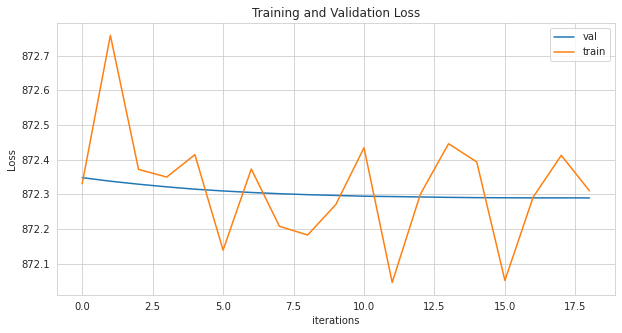

In [11]:
data.y = data.y.type(torch.FloatTensor)

transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)
print(train_data, val_data, test_data)
# conventional_ml(train_data)
model = GCN(in_channels=train_data.x.shape[1], hidden_channels=train_data.x.shape[1],
            out_channels=1)
# from utils import mse

# y_true = data.y.cpu().detach().numpy()
# y_hat = np.mean(y_true)
# print(mse(np.array([y_hat] * y_true.shape[0]), y_true))

# model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
epochs = 20
train_losses = []
val_losses = []
for epoch in range(1, 20):
    loss = train(model)
    test_loss = test(model)
    train_losses.append(loss.item())
    val_losses.append(test_loss.item())
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
print(model)
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import io
from google.colab import files
uploaded = files.upload()

Saving mains_1.graphml to mains_1.graphml


In [ ]:
# missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #Sometimes Missing Values are't in form of NaN
# data = nx.read_graphml(io.BytesIO(uploaded['mains_1.csv'])) 
# print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

In [ ]:
data = g
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')